# Background 


### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import collections
import hashlib
import numbers
from datetime import datetime
from pathlib import Path
import os

import sys
sys.path.append('../')
import spiking_cell_bare as spiking_cell
import adding_problem


In [2]:
# Training Parameters
# Training Parameters
weight_learning_rate = 1e-3
training_steps = 4000
batch_size = 100
training_size=batch_size*training_steps
epochs=10
test_size=1000
display_step = 200
grad_clip=100
# Network Parameters
num_input = 2 # adding problem data input (first input are the random digits , second input is the mask)
time_steps = 50
num_units_input_layer=50
num_hidden = 200 # hidden layer num of features
num_output = 1 # value of the addition estimation
#
# save dir
# create a training and testing dataset
training_x, training_y = adding_problem.get_batch(batch_size=training_size,time_steps=time_steps)
testing_x, testing_y = adding_problem.get_batch(batch_size=test_size,time_steps=time_steps)

savepath='/home/eghbal/Desktop/bp_snn_add_T_5e+01_eta_W_1e-03_batch_1e+02_hum_hidd_2e+02_gc_1e+02_steps_4e+03_epoch_1e+01_run_20190310_2218/'

In [3]:
def _hinton_identity_initializer(shape,dtype=None,partition_info=None,verify_shape=None, max_val=1):
    if dtype is None:
        dtype=tf.float32
    #extract second dimension
    W_rec=tf.eye(shape[-1],dtype=dtype)
    new_shape=[shape[0]-shape[-1],shape[-1]]
    W_in=tf.random_normal(new_shape,mean=0,stddev=0.001)
    return tf.concat([W_in,W_rec],axis=0)

## define KeRNL unit
def bptt_snn_all_states(x,context):
    with tf.variable_scope('input_layer') as scope:
        input_layer_cell=spiking_cell.input_spike_cell(num_units=num_units_input_layer)
        output_l1, states_l1 = tf.nn.dynamic_rnn(input_layer_cell, dtype=tf.float32, inputs=x)
    with tf.variable_scope('hidden_layer') as scope:
        hidden_layer_cell=spiking_cell.conductance_spike_cell(num_units=num_hidden,output_is_tuple=True,tau_refract=2.0,tau_m=20.0,kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_hidden, states_hidden = tf.nn.dynamic_rnn(hidden_layer_cell, dtype=tf.float32, inputs=tf.concat([output_l1,context],-1))
    with tf.variable_scope('output_layer') as scope :
        output_layer_cell=spiking_cell.output_spike_cell(num_units=num_output,kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_voltage, voltage_states=tf.nn.dynamic_rnn(output_layer_cell,dtype=tf.float32,inputs=output_hidden.spike)
    return output_voltage,output_hidden, output_l1

tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    BATCH_SIZE=tf.placeholder(tf.int64)
    X = tf.placeholder("float", [None, time_steps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    # define a dataset
    dataset=tf.data.Dataset.from_tensor_slices((X,Y)).batch(BATCH_SIZE).repeat()
    dataset = dataset.shuffle(buffer_size=200)
    iter = dataset.make_initializable_iterator()
    inputs,labels =iter.get_next()
    # define a function for extraction of variable names
    bptt_output,bptt_hidden_states,hidden_inputs=bptt_snn_all_states(tf.expand_dims(inputs[:,:,0],axis=-1),tf.expand_dims(inputs[:,:,1],axis=-1))
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    #
    find_join_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for bptt
    with tf.name_scope('bptt_Trainables') as scope:
        bptt_output_weight_index= find_join_index(trainables,'output_layer','kernel')
        bptt_kernel_index= find_join_index(trainables,'hidden_layer','kernel')
        bptt_weight_training_indices=np.asarray([bptt_kernel_index,bptt_output_weight_index],dtype=np.int)
        bptt_weight_trainables= [trainables[k] for k in bptt_weight_training_indices]

    with tf.name_scope('bptt_train_weights') as scope:
        bptt_weight_optimizer = tf.train.RMSPropOptimizer(learning_rate=weight_learning_rate)
        bptt_loss_output_prediction=tf.losses.mean_squared_error(labels,bptt_output[:,-1,:])
        #bptt_grad_cost_trainables=tf.gradients(bptt_loss_output_prediction,bptt_weight_trainables)
        bptt_grad_cost_trainables=bptt_weight_optimizer.compute_gradients(bptt_loss_output_prediction,trainables)
        bptt_weight_train_op = bptt_weight_optimizer.apply_gradients(bptt_grad_cost_trainables)
        #bptt_weight_grads_and_vars=list(zip(bptt_grad_cost_trainables,bptt_weight_trainables))
        #bptt_cropped_weight_grads_and_vars=[(tf.clip_by_norm(grad, grad_clip),var) if  np.unicode_.find(var.name,'output')==-1 else (grad,var) for grad,var in bptt_weight_grads_and_vars]
        #bptt_weight_train_op = bptt_weight_optimizer.apply_gradients(bptt_cropped_weight_grads_and_vars)


            ##################
            ## bptt train ####
            ##################

    with tf.name_scope("bptt_evaluate") as scope:
        bptt_loss_cross_validiation=tf.losses.mean_squared_error(labels,bptt_output[:,-1,:])

    with tf.name_scope('cross_validation_summary') as scope:
        tf.summary.scalar('cross_validation_summary',bptt_loss_cross_validiation+1e-10)
        bptt_evaluate_summary_op=tf.summary.merge_all(scope="cross_validation_summary")

                ##################
                # SUMMARIES ######
                ##################

    with tf.name_scope("bptt_weight_summaries") as scope:

        #
        #tf.summary.histogram('bptt_kernel_grad',bptt_grad_cost_trainables[0]+1e-10)
        #tf.summary.histogram('bptt_kernel', trainables[0]+1e-10)
                    # bptt output weight
        #tf.summary.histogram('bptt_output_weight_grad',bptt_grad_cost_trainables[1]+1e-10)
        #tf.summary.histogram('bptt_output_weights', trainables[1]+1e-10)
                    # bptt loss and accuracy
        tf.summary.scalar('bptt_loss_output_prediction',bptt_loss_output_prediction+1e-10)

        # bptt senstivity tensor and temporal filter
        bptt_merged_summary_op=tf.summary.merge_all(scope="bptt_weight_summaries")

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# verify initialization

In [4]:
with tf.Session(graph=graph) as sess: 
    saver.restore(sess, savepath+'model.ckpt')
    values,trainable_vars = sess.run([variable_names,trainables])
    sess.run(iter.initializer,feed_dict={X: training_x, Y: training_y , BATCH_SIZE: batch_size})
    batch_x,batch_y, outputs,hiddens,input_layer=sess.run([inputs,labels,bptt_output,bptt_hidden_states,hidden_inputs])

INFO:tensorflow:Restoring parameters from /home/eghbal/Desktop/bp_snn_add_T_5e+01_eta_W_1e-03_batch_1e+02_hum_hidd_2e+02_gc_1e+02_steps_4e+03_epoch_1e+01_run_20190310_2218/model.ckpt


In [ ]:
with tf.Session(graph=graph) as sess: 
    #saver.restore(sess, savepath+'model.ckpt')
    sess.run(init)
    values,trainable_vars = sess.run([variable_names,trainables])
    sess.run(iter.initializer,feed_dict={X: training_x, Y: training_y , BATCH_SIZE: batch_size})
    batch_x,batch_y, outputs,hiddens,input_layer=sess.run([inputs,labels,bptt_output,bptt_hidden_states,hidden_inputs])

Text(0, 0.5, 'output class')

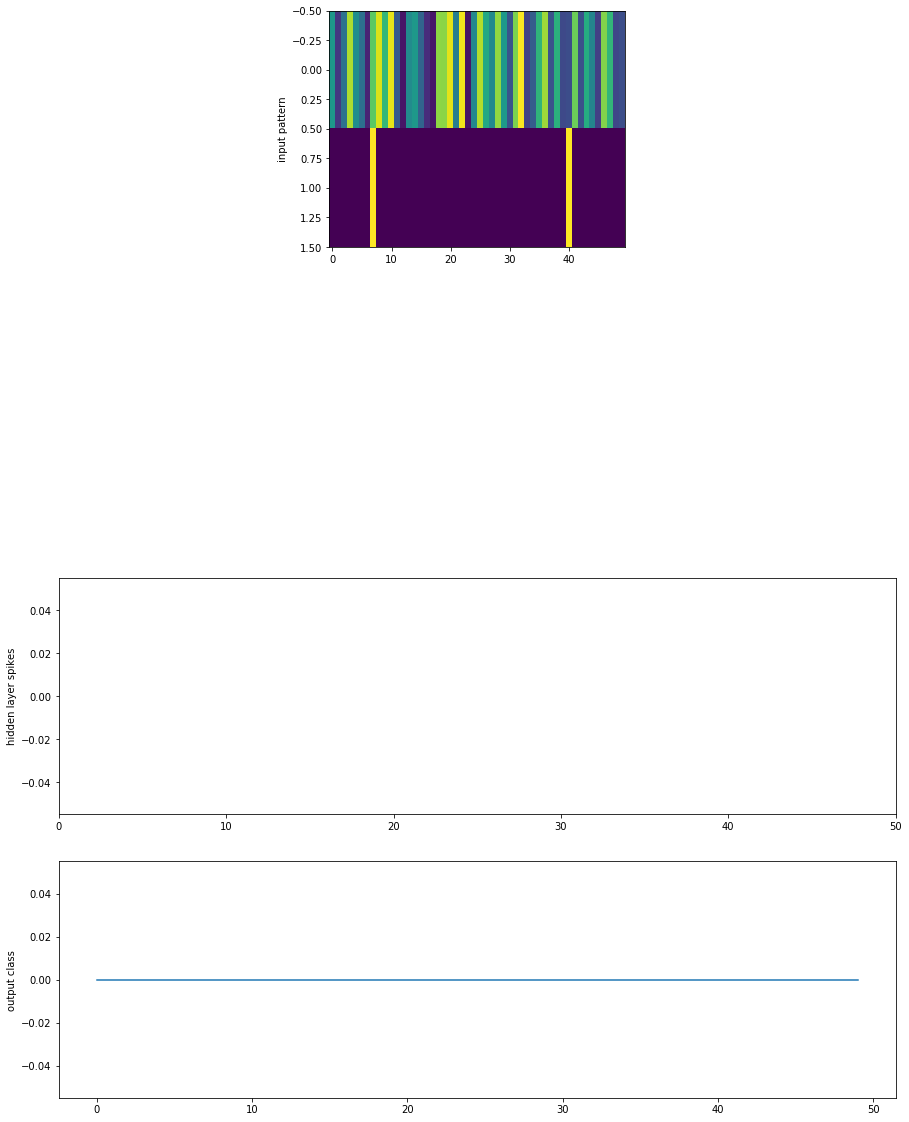

In [5]:
voltages=outputs[9,:,:]
hidden_spikes=hiddens.spike[9,:,:]
plt.figure(figsize=[15,20])


ax1=plt.subplot(411)
plt.imshow(np.transpose(batch_x[9]))
ax1.set_aspect(20)
plt.ylabel('input pattern')

ax3=plt.subplot(413)
colors_map=cm.viridis(np.linspace(0,1,num_hidden))
for t in range(time_steps):
    cross=np.argwhere(hidden_spikes[t,:])
    ax3.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
plt.ylabel('hidden layer spikes')
ax1=plt.subplot(414)
ax1.plot(voltages)

plt.ylabel('output class')

    

(50, 200)


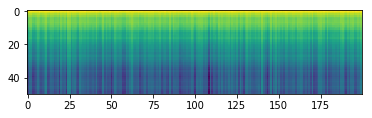

In [6]:
hidden_voltages=hiddens.v_mem[1,:,:]
print(hidden_voltages.shape)
plt.imshow(hidden_voltages)

(50, 50)


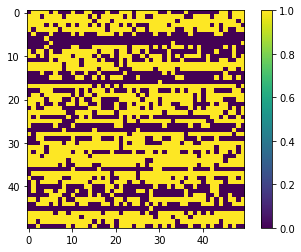

In [7]:
hidden_voltages=input_layer[1,:,:]
print(hidden_voltages.shape)
plt.imshow(hidden_voltages)
plt.colorbar()

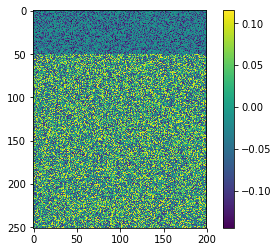

In [8]:
plt.imshow(values[0])
plt.colorbar()

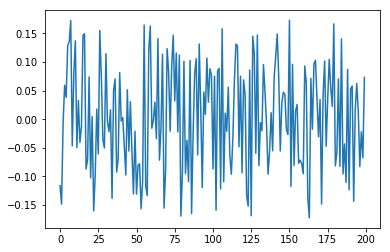

In [9]:
plt.plot(values[1])


['hidden_layer/rnn/conductance_spike_cell/kernel:0',
 'output_layer/rnn/output_spike_cell/kernel:0']